In [562]:
from scipy.stats import poisson
import copy
import os
import itertools
import pickle
import random
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
% matplotlib inline

In [563]:
distribution = 'poisson'
environment = 'simple'
exp_name = distribution + '_' + environment + '_discount0.5'
results_dir = '/Users/kunal/Workspace/RL/car_rental_results/' + exp_name + '/'
policy_dump_file = results_dir + 'policy_dump'
state_values_dump_file = results_dir + 'state_values_dump'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [564]:
num_stations = 2
moving_cost = 2
parking_cost = 3
max_parking_slots = 3
rent_reward = 10
moving_capacity = 3
cap0, cap1 = 6, 6
lambda_req0, lambda_req1 = 2, 3
lambda_ret0, lambda_ret1 = 2, 1

num_steps = 1000
# Poisson Distribution for requests and returns
requests = np.random.poisson(lam=(lambda_req0, lambda_req1), size=(num_steps, num_stations))
returns = np.random.poisson(lam=(lambda_ret0, lambda_ret1), size=(num_steps, num_stations))

In [565]:
samples = np.random.poisson(lam=(lambda_req0, lambda_req1, lambda_ret0, lambda_ret1), size=(num_steps, 4))

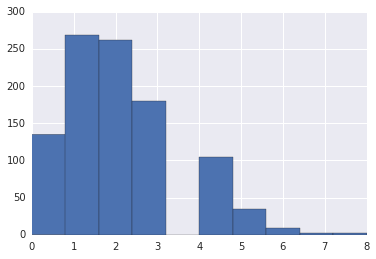

In [566]:
plt.hist([sample[0] for sample in samples])
plt.show()

In [567]:
state_lists = [range(0, cap0 + 1), range(0, cap1 + 1)]
states = list(itertools.product(*state_lists))
actions = range(-moving_capacity, moving_capacity + 1, 1)
# discount_rate = 0.5
discount_rate = 0
if environment == 'simple':
    max_policy_eval_iterations = 3
else:
    max_policy_eval_iterations = 10
max_iterations = 20

In [568]:
# Plotting methods
def plot_policy(policy, acts):
    fig = plt.figure()
    ax = plt.subplot(111)
    for action in acts:
        action_states = [state for state in states if policy[state] == action]
        x_val = [elem[1] for elem in action_states]
        y_val = [elem[0] for elem in action_states] 
        ax.plot(x_val, y_val, label=action)
    ax.set_xlabel('#Cars at location 1')
    ax.set_ylabel('#Cars at location 0')
    ax.set_xlim(-0.5, cap1 + 0.5)
    ax.set_ylim(-0.5, cap0 + 0.5)
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_policy_dump():
    with open(policy_dump_file, 'rb') as f:
        policy_dump = pickle.load(f)
    ncols = len(policy_dump)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(21,4))
    for i in range(ncols):
        ax = axs[i]
        policy = policy_dump[i]
        for action in actions:
            action_states = [state for state in states if policy[state] == action]
            x_val = [elem[1] for elem in action_states]
            y_val = [elem[0] for elem in action_states] 
            ax.plot(x_val, y_val, label=action)
            ax.set_xlabel('#Cars at location 1')
            ax.set_ylabel('#Cars at location 0')
            ax.set_xlim(-0.5, cap1 + 0.5)
            ax.set_ylim(-0.5, cap0 + 0.5)
            # Shrink current axis by 20%
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            axs[i].set_title('Policy{0}'.format(i))
    plt.show()

def plot_state_values(V, dim0, dim1):
    x = range(0, dim1 + 1)
    y = range(0, dim0 + 1)
    matrix = np.array([[V[(y_val, x_val)] for y_val in y] for x_val in x])
    # cmap = sns.cubehelix_palette(8, as_cmap=True)
    cmap = None
    sns.heatmap(matrix, cmap=cmap)

In [569]:
# Helper methods
def get_poisson_probability(req0, req1, ret0, ret1):
    if req0 < cap0:
        preq0 = poisson.pmf(req0, lambda_req0)
    else:
        preq0 = (1 - poisson.cdf(cap0 - 1, lambda_req0)) 
    
    if req1 < cap1:
        preq1 = poisson.pmf(req1, lambda_req1)
    else:
        preq1 = 1 - poisson.cdf(cap1 - 1, lambda_req1)
    
    if ret0 < cap0:
        pret0 = poisson.pmf(ret0, lambda_ret0)
    else:
        pret0 = 1 - poisson.cdf(cap0 - 1, lambda_ret0)
    
    if ret1 < cap1:
        pret1 = poisson.pmf(ret1, lambda_ret1)
    else:
        pret1 = 1 - poisson.cdf(cap1 - 1, lambda_ret1)

    return preq0 * preq1 * pret0 * pret1

def get_uniform_probability(req0_max, req1_max, ret0_max, ret1_max):
    preq0 = 1.0 / (req0_max + 1)
    preq1 = 1.0 / (req1_max + 1)
    pret0 = 1.0 / (ret0_max + 1)
    pret1 = 1.0 / (ret1_max + 1)
    return preq0 * preq1 * pret0 * pret1

def update_station(c, req, ret, cap, action):
    # Can't transfer more than current capacity
    if action > c:
        return -1, 0
    # Can't store more than max capacity
    avail = min(cap0, c - action)
    # Give cars for rent
    c_next = min(0, avail - req)
    # Compute reward
    reward = min(avail, req) * rent_reward
    # Add back returned cars
    c_next = min(cap, c_next + ret) 
    return c_next, reward
    
def exp_poisson_value(state, action, V):
    c0, c1 = state[0], state[1]
    assert (c0 <= cap0) and (c1 <= cap1)
    exp_value = 0
    for req0 in range(0, cap0 + 1):
        for req1 in range(0, cap1 + 1):
            for ret0 in range(0, cap0 + 1):
                c0_next, reward0 = update_station(c0, req0, ret0, cap0, action)
                if c0_next < 0:
                    continue
                for ret1 in range(0, cap1 + 1):
                    c1_next, reward1 = update_station(c1, req1, ret1, cap1, -action)
                    if c1_next < 0:
                        continue
                    # Compute discounted value
                    next_state = (c0_next, c1_next)
                    total_reward = reward0 + reward1 - get_cost(c0, c1, action)
                    if distribution == 'poisson':
                        probability = get_poisson_probability(req0 ,req1, ret0, ret1)
                    else:
                        probability = get_uniform_probability(cap0 ,cap1, cap0, cap1)
                    exp_value += probability * (total_reward + discount_rate * V[next_state])
    return exp_value

def get_uniform_max_value(x):
    y = 2 * x
    if x % 2 != 0:
        y += 1
    return y

def get_cost(c0, c1, action):
    cost = 0
    if environment == 'complex':
        if action > 0:
            cost = abs(action - 1) * moving_cost
        else:
            cost = abs(action) * moving_cost
        if c0 > max_parking_slots:
            cost += parking_cost
        if c1 > max_parking_slots:
            cost += parking_cost
    else:
        cost = abs(action) * moving_cost
    return cost
    
def exp_uniform_value(state, action, V):
    c0, c1 = state[0], state[1]
    assert (c0 <= cap0) and (c1 <= cap1)
    exp_value = 0
    req0_max = get_uniform_max_value(lambda_req0)
    req1_max = get_uniform_max_value(lambda_req1)
    ret0_max = get_uniform_max_value(lambda_ret0)
    ret1_max = get_uniform_max_value(lambda_ret1)
    for req0 in range(0, req0_max + 1):
        for req1 in range(0, req1_max + 1):
            for ret0 in range(0, ret0_max + 1):
                c0_next, reward0 = update_station(c0, req0, ret0, cap0, action)
                if c0_next < 0:
                    continue
                for ret1 in range(0, ret1_max + 1):
                    c1_next, reward1 = update_station(c1, req1, ret1, cap1, -action)
                    if c1_next < 0:
                        continue
                    # Compute discounted value
                    next_state = (c0_next, c1_next)
                    total_reward = reward0 + reward1 - get_cost(c0, c1, action)
                    probability = get_uniform_probability(req0_max, req1_max, ret0_max, ret1_max)
                    exp_value += probability * (total_reward + discount_rate * V[next_state])
    return exp_value

def get_exp_value(state, action, V):
    if distribution == 'uniform_non_symmetric':
        return exp_uniform_value(state, action, V)
    return exp_poisson_value(state, action, V)

In [570]:
# Policy Iteration methods
def policy_eval(policy, V):
    theota = 0.0001
    iteration = 0
    while True and iteration < max_policy_eval_iterations:
        iteration += 1
        delta = 0
        for state in states:
            v = V[state]
            V[state] = get_exp_value(state, policy[state], V)
            delta = max(delta, abs(v - V[state]))
        print('Iteration = {0} Delta = {1}'.format(iteration, delta))
        if delta < theota:
            print('Policy evaluation converged after {0} iterations. Max Delta = {1}\n'.format(iteration, delta))
            break
            
def policy_improvement(policy, V, state_space):
    policy_stable = True
    stable_states = 0
    for state in state_space:
#         print('\nFinding best action for state {0}'.format(state))
        old_action = policy[state]
        max_value, max_action = 0, None
        for action in actions:
#             print('Evaluating action: {0}'.format(action))
            value = get_exp_value(state, action, V)
#             print('Action value: {0}'.format(value))
            if (max_action is None):
                max_action = action
                max_value = value
                continue
            # If two policies have same values choose the one which shifts lesser number of cars
            if (max_value < value) or (max_value == value and abs(max_action) > abs(action)):
#                 print('Updating max value action to {0}'.format(action))
                max_value = value
                max_action = action
        assert max_action is not None
        policy[state] = max_action
        if old_action == policy[state]:
            stable_states += 1
        else:
            policy_stable = False
    print('\n#Stable States:{0} Policy Stable: {1}'.format(stable_states, policy_stable))
    return policy_stable

def policy_iteration():
    # Initialize policy randomly
#     policy = {state : random.choice(actions) for state in states}
    policy = {state : 0 for state in states}
    # Dictionary to store policy at each iteration
    policy_dump = {0: copy.deepcopy(policy)}
    # Initialize all states to 0
    V = {state : 0 for state in states}
    policy_stable = False
    iteration = 1
    while not policy_stable and iteration < max_iterations:
        print '\nExecuting policy eval iter:{0}'.format(iteration)
        policy_eval(policy, V)
        print '\nExecuting policy improvement iter:{0}'.format(iteration)
        policy_stable = policy_improvement(policy, V, states)
        # Store policy for plotting later
        policy_dump[iteration] = copy.deepcopy(policy)
        iteration += 1
    return V, policy, policy_dump

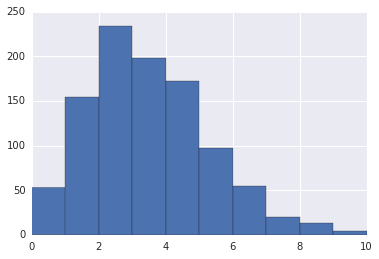

In [571]:
plt.hist([request[1] for request in requests])
plt.show()

In [572]:
V_star, policy_star, policy_dump = policy_iteration()


Executing policy eval iter:1
Iteration = 1 Delta = 49.4337300196
Iteration = 2 Delta = 0
Policy evaluation converged after 2 iterations. Max Delta = 0


Executing policy improvement iter:1

#Stable States:18 Policy Stable: False

Executing policy eval iter:2
Iteration = 1 Delta = 20.3352889667
Iteration = 2 Delta = 0
Policy evaluation converged after 2 iterations. Max Delta = 0


Executing policy improvement iter:2

#Stable States:49 Policy Stable: True


In [573]:
# Dump the poclicies for plotting later
with open(policy_dump_file, 'wb') as f:
    pickle.dump(policy_dump, f)

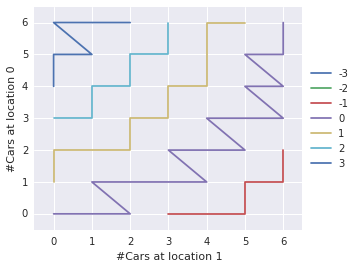

In [574]:
plot_policy(policy_star, actions)

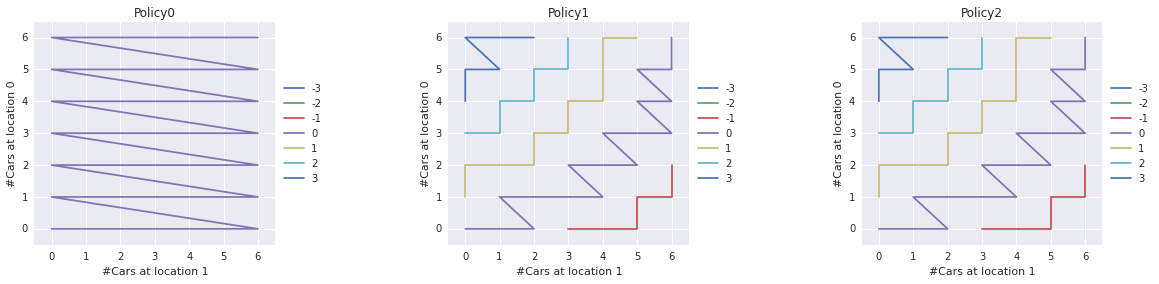

In [575]:
plot_policy_dump()

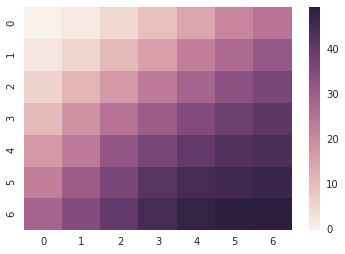

In [576]:
plot_state_values(V_star, cap0, cap1)

In [577]:
for y in range(0, cap0 + 1):
    for x in range(0, cap1 + 1):
        print('State: ({0},{1}) = {2}'.format(y, x, V_star[(y,x)]))

State: (0,0) = 0.0
State: (0,1) = 2.20841412314
State: (0,2) = 5.96840629467
State: (0,3) = 10.7735771055
State: (0,4) = 17.0704349313
State: (0,5) = 22.3021610991
State: (0,6) = 28.6785322868
State: (1,0) = 1.70663238391
State: (1,1) = 5.55277255822
State: (1,2) = 11.7420708831
State: (1,3) = 18.3017084636
State: (1,4) = 23.7123610616
State: (1,5) = 30.3012284152
State: (1,6) = 34.8674788953
State: (2,0) = 4.90228353046
State: (2,1) = 10.7735771055
State: (2,2) = 17.0704349313
State: (2,3) = 25.1094379817
State: (2,4) = 31.9239245437
State: (2,5) = 36.6125494105
State: (2,6) = 40.3764504432
State: (3,0) = 9.80508332804
State: (3,1) = 15.8391613989
State: (3,2) = 23.692629836
State: (3,3) = 30.3012284152
State: (3,4) = 37.0124725522
State: (3,5) = 42.2409154319
State: (3,6) = 45.0478330139
State: (4,0) = 14.6078878665
State: (4,1) = 22.2758216903
State: (4,2) = 28.6785322868
State: (4,3) = 35.2787545777
State: (4,4) = 40.3764504432
State: (4,5) = 44.9998107095
State: (4,6) = 47.9348134

In [578]:
# params = ['c0', 'c1', 'lambda_req0', 'lambda_req1', 'lambda_ret0', 'lambda_ret1', 'moving_cost', 'rent_reward']
params = ['c0', 'c1']
X_train = np.zeros(((cap0 + 1) * (cap1 + 1), len(params)))
y_train = np.zeros((cap0 + 1) * (cap1 + 1))
i = 0
for c0 in range(0, cap0 + 1):
    for c1 in range(0, cap1 + 1):
#         X_train[i] = np.array([c0, c1, lambda_req0, lambda_req1, lambda_ret0, lambda_ret1, moving_cost, rent_reward])
        X_train[i, :] = np.array([c0, c1])
        y_train[i] = V_star[(c0, c1)]
        i += 1

In [579]:
cap0_test, cap1_test = 20, 20
X_test = np.zeros(((cap0_test + 1) * (cap0_test + 1), len(params)))
lambda_req0_test = 3
lambda_req1_test = 4
lambda_ret0_test = 3
lambda_ret1_test = 2
i = 0
for c0 in range(0, cap0_test + 1):
    for c1 in range(0, cap0_test + 1):
#          X_test[i] = np.array([c0, c1, lambda_req0_test, lambda_req1_test, lambda_ret0_test, lambda_ret1_test,
#                                 moving_cost, rent_reward])
        X_test[i] = np.array([c0, c1])
        i += 1
y_test = regr.predict(X_test)

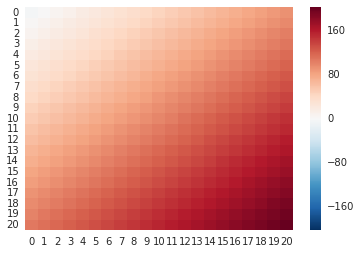

In [580]:
from sklearn.svm import SVR
clf = SVR(C=1, epsilon=0.2, kernel='linear')
clf.fit(X_train, y_train)
# y_train_pred = clf.predict(X_train)
y_test = clf.predict(X_test)
V_test = np.reshape(y_test, [cap0_test + 1, cap1_test + 1])
plot_state_values(V_test, cap0_test, cap1_test)

In [581]:
with open(state_values_dump_file, 'wb') as f:
    pickle.dump(V_test, f)

In [582]:
state_values_dump_file

'/Users/kunal/Workspace/RL/car_rental_results/poisson_simple_discount0.5/state_values_dump'